In [1]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

print("Device:", device)


Device: cpu


Frame path: ../data/segments_16/train/Fighting/Fighting002_x264/seg_0011/frame_10.png


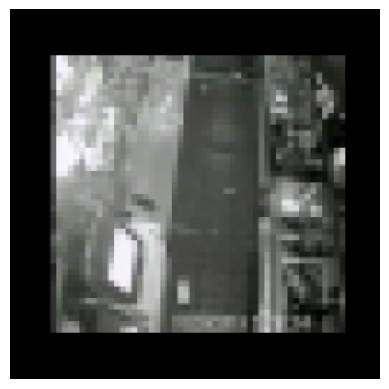

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt

base_dir = "../data/segments_16/train/Fighting"
video_dir = os.path.join(base_dir, os.listdir(base_dir)[0])
segment_dir = os.path.join(video_dir, os.listdir(video_dir)[0])
frame_name = os.listdir(segment_dir)[0]
image_path = os.path.join(segment_dir, frame_name)
image = Image.open(image_path)

plt.imshow(image)
plt.axis("off")

print("Frame path:", image_path)

In [3]:
texts = [
    "a person fighting",
    "people walking normally",
    "a peaceful street scene",
    "a violent action",
    "a robbery happening"
]

text_tokens = clip.tokenize(texts).to(device)


In [4]:
with torch.no_grad():
    image_input = preprocess(image).unsqueeze(0).to(device)
    image_embedding = model.encode_image(image_input)
    text_embeddings = model.encode_text(text_tokens)


In [5]:
import torch.nn.functional as F

image_embedding = F.normalize(image_embedding, dim=-1)
text_embeddings = F.normalize(text_embeddings, dim=-1)

similarity = image_embedding @ text_embeddings.T


In [6]:
for i, text in enumerate(texts):
    print(f"{text:30s} : {similarity[0][i].item():.4f}")


a person fighting              : 0.2281
people walking normally        : 0.2292
a peaceful street scene        : 0.1980
a violent action               : 0.2246
a robbery happening            : 0.2283


In [7]:
segment_dir = os.path.join(
    "../data/segments_16/train/Fighting",
    os.listdir("../data/segments_16/train/Fighting")[0],
    os.listdir(
        os.path.join("../data/segments_16/train/Fighting",
                     os.listdir("../data/segments_16/train/Fighting")[0])
    )[0]
)

print("Selected segment:", segment_dir)


Selected segment: ../data/segments_16/train/Fighting/Fighting002_x264/seg_0011


In [8]:
def compute_segment_embedding(segment_dir):
    frame_embeddings = []

    frame_files = sorted(os.listdir(segment_dir))
    print("Using frames:", frame_files[:3], "...")

    for frame_name in frame_files:
        frame_path = os.path.join(segment_dir, frame_name)

        image = Image.open(frame_path)
        image_input = preprocess(image).unsqueeze(0).to(device)

        with torch.no_grad():
            emb = model.encode_image(image_input)

        frame_embeddings.append(emb)

    frame_embeddings = torch.cat(frame_embeddings, dim=0)
    segment_embedding = frame_embeddings.mean(dim=0, keepdim=True)

    return segment_embedding


In [9]:
segment_embedding = compute_segment_embedding(segment_dir)
print("Segment embedding shape:", segment_embedding.shape)


Using frames: ['frame_00.png', 'frame_01.png', 'frame_02.png'] ...
Segment embedding shape: torch.Size([1, 512])


In [10]:
texts = [
    "a person fighting",
    "people walking normally",
    "a peaceful street scene",
    "a violent action",
    "a robbery happening"
]

text_tokens = clip.tokenize(texts).to(device)

with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens)


In [11]:
segment_embedding = F.normalize(segment_embedding, dim=-1)
text_embeddings = F.normalize(text_embeddings, dim=-1)

similarity = segment_embedding @ text_embeddings.T


In [12]:
for i, text in enumerate(texts):
    print(f"{text:30s} : {similarity[0][i].item():.4f}")


a person fighting              : 0.2278
people walking normally        : 0.2321
a peaceful street scene        : 0.1961
a violent action               : 0.2243
a robbery happening            : 0.2292


In [13]:
video_dir = os.path.join(
    "../data/segments_16/train/Fighting",
    os.listdir("../data/segments_16/train/Fighting")[0]
)

segment_dirs = sorted([
    os.path.join(video_dir, d)
    for d in os.listdir(video_dir)
])

print("Total segments:", len(segment_dirs))
print("First segments:", segment_dirs[:3])


Total segments: 16
First segments: ['../data/segments_16/train/Fighting/Fighting002_x264/seg_0000', '../data/segments_16/train/Fighting/Fighting002_x264/seg_0001', '../data/segments_16/train/Fighting/Fighting002_x264/seg_0002']


In [14]:
def segment_zero_shot_score(segment_dir, text_embeddings):
    seg_emb = compute_segment_embedding(segment_dir)
    seg_emb = F.normalize(seg_emb, dim=-1)

    sims = seg_emb @ text_embeddings.T
    max_score, best_idx = sims.max(dim=1)

    return {
        "segment": os.path.basename(segment_dir),
        "best_class": texts[best_idx.item()],
        "score": max_score.item()
    }


In [15]:
results = []

for seg_dir in segment_dirs:
    res = segment_zero_shot_score(seg_dir, text_embeddings)
    results.append(res)

results[:5]


Using frames: ['frame_00.png', 'frame_01.png', 'frame_02.png'] ...
Using frames: ['frame_00.png', 'frame_01.png', 'frame_02.png'] ...
Using frames: ['frame_00.png', 'frame_01.png', 'frame_02.png'] ...
Using frames: ['frame_00.png', 'frame_01.png', 'frame_02.png'] ...
Using frames: ['frame_00.png', 'frame_01.png', 'frame_02.png'] ...
Using frames: ['frame_00.png', 'frame_01.png', 'frame_02.png'] ...
Using frames: ['frame_00.png', 'frame_01.png', 'frame_02.png'] ...
Using frames: ['frame_00.png', 'frame_01.png', 'frame_02.png'] ...
Using frames: ['frame_00.png', 'frame_01.png', 'frame_02.png'] ...
Using frames: ['frame_00.png', 'frame_01.png', 'frame_02.png'] ...
Using frames: ['frame_00.png', 'frame_01.png', 'frame_02.png'] ...
Using frames: ['frame_00.png', 'frame_01.png', 'frame_02.png'] ...
Using frames: ['frame_00.png', 'frame_01.png', 'frame_02.png'] ...
Using frames: ['frame_00.png', 'frame_01.png', 'frame_02.png'] ...
Using frames: ['frame_00.png', 'frame_01.png', 'frame_02.png']

[{'segment': 'seg_0000',
  'best_class': 'a person fighting',
  'score': 0.23398783802986145},
 {'segment': 'seg_0001',
  'best_class': 'a person fighting',
  'score': 0.23364146053791046},
 {'segment': 'seg_0002',
  'best_class': 'a person fighting',
  'score': 0.23216956853866577},
 {'segment': 'seg_0003',
  'best_class': 'a person fighting',
  'score': 0.23359426856040955},
 {'segment': 'seg_0004',
  'best_class': 'people walking normally',
  'score': 0.23389801383018494}]

In [16]:
results_sorted = sorted(results, key=lambda x: x["score"], reverse=True)

for r in results_sorted[:10]:
    print(r)


{'segment': 'seg_0000', 'best_class': 'a person fighting', 'score': 0.23398783802986145}
{'segment': 'seg_0004', 'best_class': 'people walking normally', 'score': 0.23389801383018494}
{'segment': 'seg_0001', 'best_class': 'a person fighting', 'score': 0.23364146053791046}
{'segment': 'seg_0003', 'best_class': 'a person fighting', 'score': 0.23359426856040955}
{'segment': 'seg_0014', 'best_class': 'a person fighting', 'score': 0.23316863179206848}
{'segment': 'seg_0010', 'best_class': 'people walking normally', 'score': 0.23299339413642883}
{'segment': 'seg_0002', 'best_class': 'a person fighting', 'score': 0.23216956853866577}
{'segment': 'seg_0011', 'best_class': 'people walking normally', 'score': 0.23213446140289307}
{'segment': 'seg_0015', 'best_class': 'a person fighting', 'score': 0.23150062561035156}
{'segment': 'seg_0009', 'best_class': 'a person fighting', 'score': 0.23033258318901062}


In [17]:
top_k = 5
top_segments = results_sorted[:top_k]

anomaly_votes = sum(
    1 for r in top_segments
    if "fighting" in r["best_class"] or "violent" in r["best_class"]
)

print("Top segments:", top_segments)
print("Anomaly votes:", anomaly_votes, "/", top_k)

if anomaly_votes >= 3:
    print("VIDEO DECISION: ANOMALOUS")
else:
    print("VIDEO DECISION: NORMAL")


Top segments: [{'segment': 'seg_0000', 'best_class': 'a person fighting', 'score': 0.23398783802986145}, {'segment': 'seg_0004', 'best_class': 'people walking normally', 'score': 0.23389801383018494}, {'segment': 'seg_0001', 'best_class': 'a person fighting', 'score': 0.23364146053791046}, {'segment': 'seg_0003', 'best_class': 'a person fighting', 'score': 0.23359426856040955}, {'segment': 'seg_0014', 'best_class': 'a person fighting', 'score': 0.23316863179206848}]
Anomaly votes: 4 / 5
VIDEO DECISION: ANOMALOUS
